# IMPORTING LIBRARIES

In [12]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import os
import math
import matplotlib.pyplot as py
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LOADING DATA USING DATASET AND DATALOADER CLASSES OF PYTORCH

In [307]:
class adsorption_dataset(Dataset):
    def __init__(self):
        self.xy=np.loadtxt('Adsorption_Data.csv',delimiter=',',dtype=np.float64,skiprows=1)
        self.data=torch.from_numpy(self.xy[0:,:5])
        self.target=torch.from_numpy(self.xy[0:,[5]])
    def __len__(self):
        return len(self.target)
    def __getitem__(self,index):
        return self.data[index],self.target[index]

# USING SKLEARN'S train_test_split TO SPLIT DATA INTO TRAINING AND TEST SETS

In [308]:
dataset = adsorption_dataset()
x=dataset.data
y=dataset.target
d=np.append(np.array(x),np.array(y),axis=1)
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=1234)
x_train=x_train.float() 

# PLOTTING ADSORPTION CAPACITY VS CARBON CONTENT

Text(0, 0.5, 'adsorption capacity')

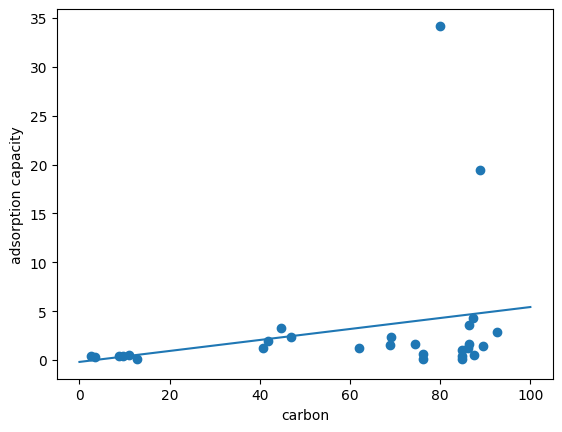

In [309]:
x=x_train[:,0].detach().cpu().numpy()
y=y_train[:,0].detach().cpu().numpy()
mymodel =np.poly1d(np.polyfit(x,y, 1))
myline = np.linspace(0,100,50)
py.scatter(x_train[:,[0]],y_train)
py.plot(myline,mymodel(myline))
py.xlabel('carbon')
py.ylabel('adsorption capacity')

# PLOTTING ADSORPTION CAPACITY VS HYDROGEN CONTENT

Text(0, 0.5, 'adsorption capacity')

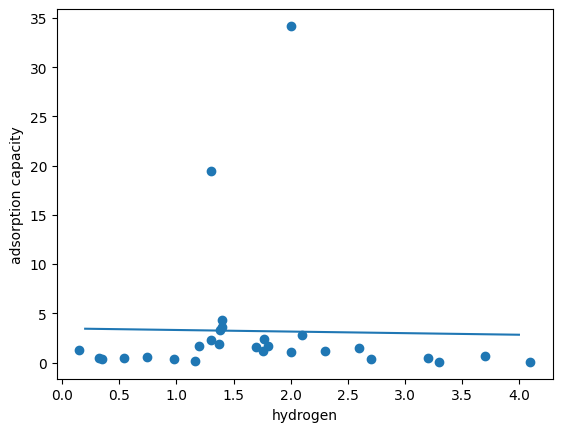

In [310]:
x=x_train[:,1].detach().cpu().numpy()
y=y_train[:,0].detach().cpu().numpy()
mymodel =np.poly1d(np.polyfit(x,y, 1))
myline = np.linspace(0.2,4,50)
py.scatter(x_train[:,[1]],y_train)
py.plot(myline,mymodel(myline))
py.xlabel('hydrogen')
py.ylabel('adsorption capacity')

# PLOTTING ADSORPTION CAPACITY VS NITROGEN CONTENT

Text(0, 0.5, 'adsorption capacity')

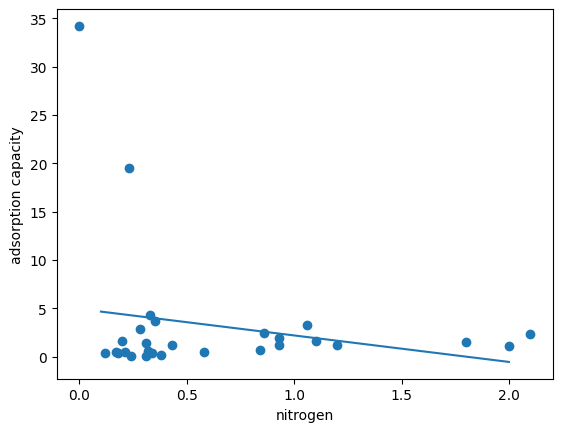

In [311]:
x=x_train[:,2].detach().cpu().numpy()
y=y_train[:,0].detach().cpu().numpy()
mymodel =np.poly1d(np.polyfit(x,y, 1))
myline = np.linspace(0.1,2,50)
py.scatter(x_train[:,[2]],y_train)
py.plot(myline,mymodel(myline))
py.xlabel('nitrogen')
py.ylabel('adsorption capacity')

# PLOTTING ADSORPTION CAPACITY VS SILICON CONTENT

Text(0, 0.5, 'adsorption capacity')

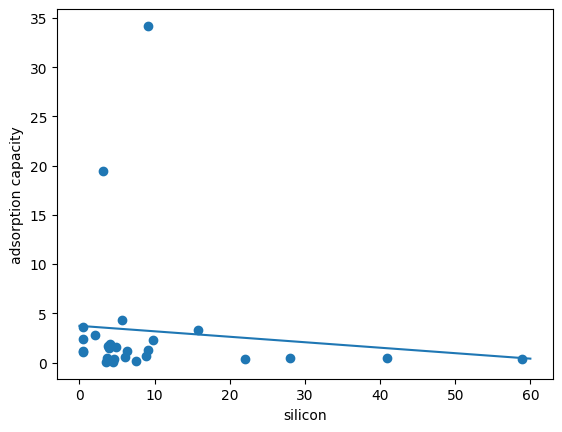

In [312]:
x=x_train[:,3].detach().cpu().numpy()
y=y_train[:,0].detach().cpu().numpy()
mymodel =np.poly1d(np.polyfit(x,y,1))
myline = np.linspace(0,60,50)
py.scatter(x_train[:,[3]],y_train)
py.plot(myline,mymodel(myline))
py.xlabel('silicon')
py.ylabel('adsorption capacity')

# PLOTTING ADSORPTION CAPACITY VS BET SURFACE AREA

Text(0, 0.5, 'adsorption capacity')

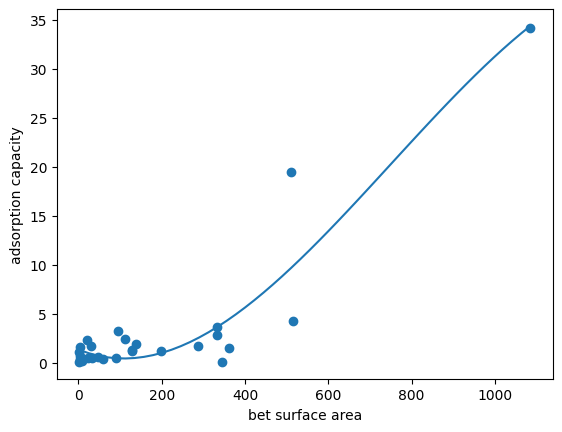

In [313]:
x=x_train[:,4].detach().cpu().numpy()
y=y_train[:,0].detach().cpu().numpy()
mymodel =np.poly1d(np.polyfit(x,y, 3))
myline = np.linspace(2.5,1085,50)
py.scatter(x_train[:,[4]],y_train)
py.plot(myline,mymodel(myline))
py.xlabel('bet surface area')
py.ylabel('adsorption capacity')

In [314]:
CH=np.array(d[:,0])/np.array(d[:,1])
CSi=np.array(d[:,0])/np.array(d[:,3])
d=np.insert(d,0,CH,axis=1)
d=np.insert(d,0,CSi,axis=1)

Text(0, 0.5, 'ad')

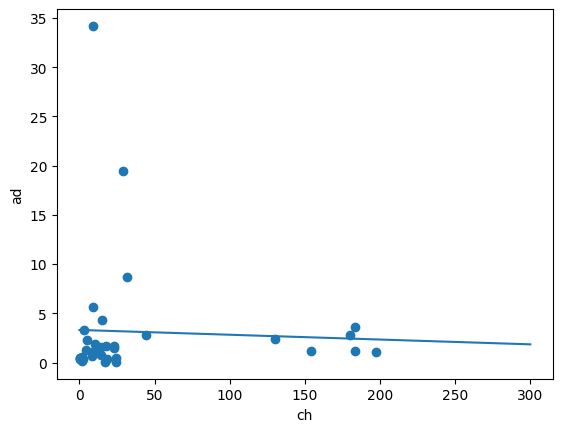

In [317]:
x=d[:,0]
y=d[:,7]
mymodel =np.poly1d(np.polyfit(x,y, 1))
myline = np.linspace(0,300,50)
py.scatter(d[:,0],d[:,7])
py.plot(myline,mymodel(myline))
py.xlabel('ch')
py.ylabel('ad')


# CREATING A HEAT MAP OF CORRELATION MATRIX TO SEE HOW VARIOUS PARAMETERS AFFECT ADSORPTION CAPACITY
## Adsorption capacity seems to be directly proportional to the BET surface area
## Other parameters do not show significant effect,only cabron shows slight proportionality. 

[[ 1.          0.035346    0.3831426   0.17638121  0.24716361 -0.37547193
  -0.0430819  -0.04720048]
 [ 0.035346    1.          0.21361504 -0.23306522  0.25320026 -0.16974588
   0.13587837  0.10613597]
 [ 0.3831426   0.21361504  1.          0.66152873  0.13221853 -0.58004135
   0.44058428  0.27062367]
 [ 0.17638121 -0.23306522  0.66152873  1.          0.0141564  -0.38067153
   0.1637085   0.0013669 ]
 [ 0.24716361  0.25320026  0.13221853  0.0141564   1.         -0.157786
  -0.31626332 -0.18656245]
 [-0.37547193 -0.16974588 -0.58004135 -0.38067153 -0.157786    1.
  -0.17907491 -0.09248279]
 [-0.0430819   0.13587837  0.44058428  0.1637085  -0.31626332 -0.17907491
   1.          0.78741392]
 [-0.04720048  0.10613597  0.27062367  0.0013669  -0.18656245 -0.09248279
   0.78741392  1.        ]]


Text(0.5, 1.0, 'Heat Map')

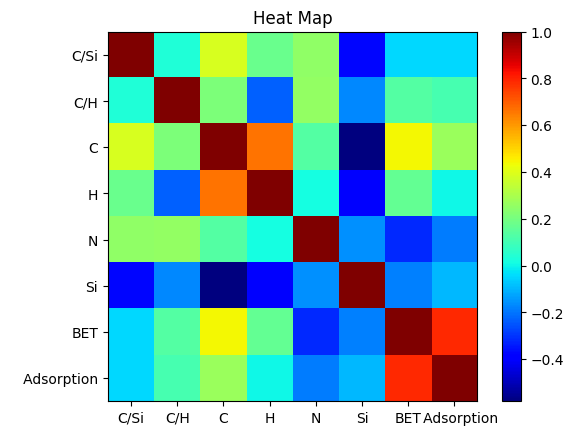

In [316]:
m=np.corrcoef(d,rowvar=False)
print(m)
py.imshow(m,cmap='jet')
py.colorbar()
labels = ['C/Si','C/H','C', 'H', 'N', 'Si','BET','   Adsorption']
py.xticks(range(len(labels)), labels)
py.yticks(range(len(labels)), labels)
py.title('Heat Map')

# CREATING AN ANN MODEL USING TORCH.NN
## After several trials a model with 5 layers: input layer, three hidden layers(with neurons 27,9,3) and the output layer seemed to be the most fitting 

In [141]:
class model(nn.Module):
    def __init__(self,input_features=5,hidden1=27,hidden2=9,hidden3=3,output=1):
        super().__init__()
        self.fc1=nn.Linear(input_features,hidden1)
        self.fc2=nn.Linear(hidden1,hidden2)
        self.fc3=nn.Linear(hidden2,hidden3)
        self.out=nn.Linear(hidden3,output)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.out(x)
        return x

### SEEDING INITIAL RANDOM VALUES IN THE FIRST HIDDEN LAYER AND INSTANTIATING THE MODEL

In [142]:
torch.manual_seed(27)
model=model()

# DEFINING LOSS FUNCTION
## We used mean squared error as our loss function

In [153]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.1)


## TRAINING THE MODEL
### Also we are printing the loss every 50th iteration 

In [144]:
epochs=1000
losses=[]
for epoch in range(epochs) :
    y_pred=model.forward(x_train)
    loss=loss_function(y_pred.float(),y_train.float())
    if(epoch%50==0):
        print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss=loss.detach().cpu().numpy()
    losses.append(loss)

tensor(78.3629, grad_fn=<MseLossBackward0>)
tensor(7.2740, grad_fn=<MseLossBackward0>)
tensor(5.0781, grad_fn=<MseLossBackward0>)
tensor(5.3998, grad_fn=<MseLossBackward0>)
tensor(5.1402, grad_fn=<MseLossBackward0>)
tensor(4.8491, grad_fn=<MseLossBackward0>)
tensor(4.3904, grad_fn=<MseLossBackward0>)
tensor(3.6048, grad_fn=<MseLossBackward0>)
tensor(8.1231, grad_fn=<MseLossBackward0>)
tensor(3.2174, grad_fn=<MseLossBackward0>)
tensor(2.8842, grad_fn=<MseLossBackward0>)
tensor(2.8297, grad_fn=<MseLossBackward0>)
tensor(2.7690, grad_fn=<MseLossBackward0>)
tensor(2.6990, grad_fn=<MseLossBackward0>)
tensor(2.6073, grad_fn=<MseLossBackward0>)
tensor(2.6810, grad_fn=<MseLossBackward0>)
tensor(2.3765, grad_fn=<MseLossBackward0>)
tensor(4.6790, grad_fn=<MseLossBackward0>)
tensor(2.3053, grad_fn=<MseLossBackward0>)
tensor(2.1463, grad_fn=<MseLossBackward0>)


# PLOTTING THE LOSSES

2.0171394


Text(0.5, 0, 'iter')

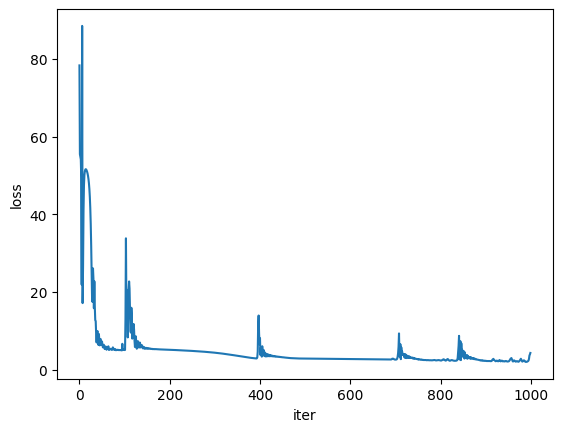

In [145]:
%matplotlib inline
print(min(losses))
py.plot(range(1000),losses)
py.ylabel('loss')
py.xlabel('iter')

# TESTING OUR MODEL

In [146]:
with torch.no_grad():
    y_pred=model(x_test.float())
    y_prediction=y_pred

# PLOTTING PREDICTED VALUES AND TRUE VALUES

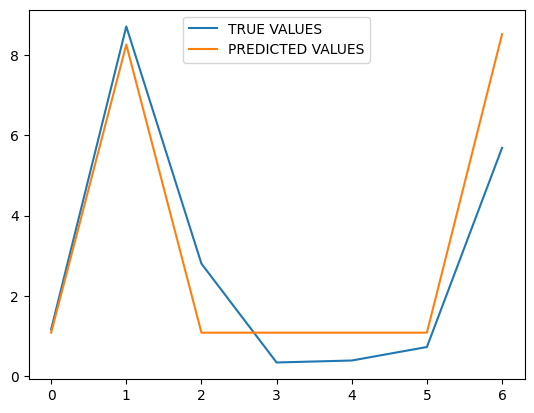

In [318]:
py.plot(y_test,label='TRUE VALUES')
py.plot(y_prediction,label='PREDICTED VALUES')
py.legend()
py.show()

# USING R2 SCORE FROM SKLEARN TO MEASURE OUR MODEL'S GOODNESS OF FIT
### Considering the given small dataset the model performs quite well.

In [148]:
from sklearn.metrics import r2_score
r2_score(y_prediction,y_test)

0.8382605151101921